In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-04 11:05:08.731652: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-04 11:05:09.549794: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-04 11:05:09.589652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 11:05:09.589716: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 11:05:09.595633: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-04 11:05:09.595708: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-04 11:05:09.597708: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

iawe_gen_GASF_60m_300S0X_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['air conditioner', 'computer', 'fridge', 'television']
{0: 4.76595744680851, 1: 0.8265682656826568, 2: 0.43118383060635224, 3: 3.8290598290598292}
 
Tests 
air conditioner test: 23 train: 94
computer test: 136 train: 542
fridge test: 260 train: 1039
television test: 30 train: 117


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/iawe/TL/iawe_12_refit, eco, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data iawe training on model refit seed 12
reading data, printing stats: 
['air conditioner', 'computer', 'fridge', 'television']
{0: 4.76595744680851, 1: 0.8265682656826568, 2: 0.43118383060635224, 3: 3.8290598290598292}
 
Tests 
air conditioner test: 23 train: 94
computer test: 136 train: 542
fridge test: 260 train: 1039
television test: 30 train: 117
loading model
compling TL model..


2022-02-04 11:05:10.092084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-04 11:05:10.092435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-04 11:05:10.092490: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-04 11:05:10.459514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-04 11:05:10.459549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-04 11:05:10.459555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-04 11:05:10.460146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-04 11:05:11.015427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-04 11:05:11.032464: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-04 11:05:11.502229: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-04 11:05:11.962385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-04 11:05:12.449737: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-04 11:05:12.875370: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


224/224 - 5s - loss: 0.7506 - accuracy: 0.7673
Epoch 2/50
224/224 - 4s - loss: 0.3711 - accuracy: 0.8510
Epoch 3/50
224/224 - 3s - loss: 0.2568 - accuracy: 0.8806
Epoch 4/50
224/224 - 4s - loss: 0.2155 - accuracy: 0.8811
Epoch 5/50
224/224 - 4s - loss: 0.1619 - accuracy: 0.9135
Epoch 6/50
224/224 - 4s - loss: 0.1488 - accuracy: 0.9224
Epoch 7/50
224/224 - 4s - loss: 0.1216 - accuracy: 0.9347
Epoch 8/50
224/224 - 4s - loss: 0.2116 - accuracy: 0.9090
Epoch 9/50
224/224 - 4s - loss: 0.1329 - accuracy: 0.9297
Epoch 10/50
224/224 - 4s - loss: 0.0669 - accuracy: 0.9559
Epoch 11/50
224/224 - 4s - loss: 0.0778 - accuracy: 0.9487
Epoch 12/50
224/224 - 4s - loss: 0.0553 - accuracy: 0.9581
Epoch 13/50
224/224 - 4s - loss: 0.1220 - accuracy: 0.9386
Epoch 14/50
224/224 - 3s - loss: 0.0915 - accuracy: 0.9442
Epoch 15/50
224/224 - 3s - loss: 0.0987 - accuracy: 0.9565
Epoch 16/50
224/224 - 4s - loss: 0.1044 - accuracy: 0.9386
Epoch 17/50
224/224 - 4s - loss: 0.0440 - accuracy: 0.9671
Epoch 18/50
224/2

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 1.4597 - accuracy: 0.6417
Epoch 2/50
224/224 - 3s - loss: 0.5708 - accuracy: 0.7762
Epoch 3/50
224/224 - 4s - loss: 0.4089 - accuracy: 0.8025
Epoch 4/50
224/224 - 3s - loss: 0.6001 - accuracy: 0.7963
Epoch 5/50
224/224 - 4s - loss: 0.3527 - accuracy: 0.7963
Epoch 6/50
224/224 - 4s - loss: 0.3896 - accuracy: 0.8192
Epoch 7/50
224/224 - 4s - loss: 0.3910 - accuracy: 0.8270
Epoch 8/50
224/224 - 4s - loss: 0.2167 - accuracy: 0.8850
Epoch 9/50
224/224 - 4s - loss: 0.2176 - accuracy: 0.8906
Epoch 10/50
224/224 - 4s - loss: 0.5879 - accuracy: 0.8499
Epoch 11/50
224/224 - 4s - loss: 0.2472 - accuracy: 0.8862
Epoch 12/50
224/224 - 4s - loss: 0.1747 - accuracy: 0.9074
Epoch 13/50
224/224 - 4s - loss: 0.1745 - accuracy: 0.9129
Epoch 14/50
224/224 - 4s - loss: 0.4194 - accuracy: 0.8482
Epoch 15/50
224/224 - 4s - loss: 0.2105 - accuracy: 0.8968
Epoch 16/50
224/224 - 4s - loss: 0.2460 - accuracy: 0.9096
Epoch 17/50
224/224 - 3s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 3.7219 - accuracy: 0.2885
Epoch 2/50
224/224 - 4s - loss: 2.1980 - accuracy: 0.4230
Epoch 3/50
224/224 - 4s - loss: 1.4827 - accuracy: 0.5123
Epoch 4/50
224/224 - 4s - loss: 0.9061 - accuracy: 0.6579
Epoch 5/50
224/224 - 4s - loss: 0.7672 - accuracy: 0.7617
Epoch 6/50
224/224 - 4s - loss: 0.6949 - accuracy: 0.7963
Epoch 7/50
224/224 - 4s - loss: 0.6030 - accuracy: 0.8064
Epoch 8/50
224/224 - 4s - loss: 0.7817 - accuracy: 0.7427
Epoch 9/50
224/224 - 4s - loss: 0.8948 - accuracy: 0.7969
Epoch 10/50
224/224 - 4s - loss: 0.4813 - accuracy: 0.8465
Epoch 11/50
224/224 - 4s - loss: 0.3929 - accuracy: 0.8683
Epoch 12/50
224/224 - 4s - loss: 0.4977 - accuracy: 0.8471
Epoch 13/50
224/224 - 4s - loss: 0.4383 - accuracy: 0.8426
Epoch 14/50
224/224 - 4s - loss: 2.3110 - accuracy: 0.8237
Epoch 15/50
224/224 - 4s - loss: 5.9314 - accuracy: 0.3516
Epoch 16/50
224/224 - 3s - loss: 0.8971 - accuracy: 0.3650
Epoch 17/50
224/224 - 4s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
224/224 - 4s - loss: 0.7102 - accuracy: 0.7868
Epoch 2/50
224/224 - 3s - loss: 0.4386 - accuracy: 0.8538
Epoch 3/50
224/224 - 4s - loss: 0.2384 - accuracy: 0.8895
Epoch 4/50
224/224 - 4s - loss: 0.2312 - accuracy: 0.9191
Epoch 5/50
224/224 - 4s - loss: 0.1395 - accuracy: 0.9157
Epoch 6/50
224/224 - 3s - loss: 0.1854 - accuracy: 0.9224
Epoch 7/50
224/224 - 3s - loss: 0.0987 - accuracy: 0.9587
Epoch 8/50
224/224 - 4s - loss: 0.0599 - accuracy: 0.9682
Epoch 9/50
224/224 - 3s - loss: 0.1373 - accuracy: 0.9492
Epoch 10/50
224/224 - 3s - loss: 0.0983 - accuracy: 0.9492
Epoch 11/50
224/224 - 4s - loss: 0.1019 - accuracy: 0.9626
Epoch 12/50
224/224 - 3s - loss: 0.1488 - accuracy: 0.9448
Epoch 13/50
224/224 - 4s - loss: 0.1013 - accuracy: 0.9676
Epoch 14/50
224/224 - 4s - loss: 0.0518 - accuracy: 0.9749
Epoch 15/50
224/224 - 4s - loss: 0.0452 - accuracy: 0.9794
Epoch 16/50
224/224 - 4s - loss: 0.0339 - accuracy: 0.9838
Epoch 17/50
224/224 - 4s - loss:

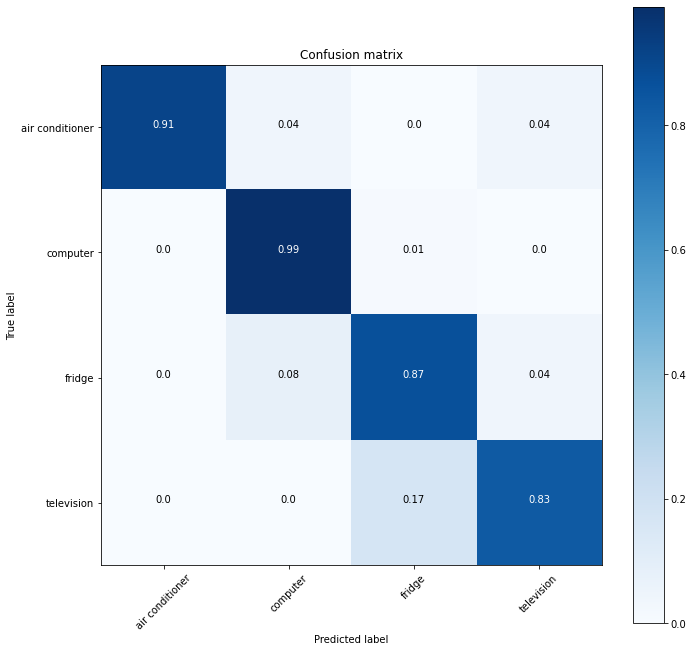

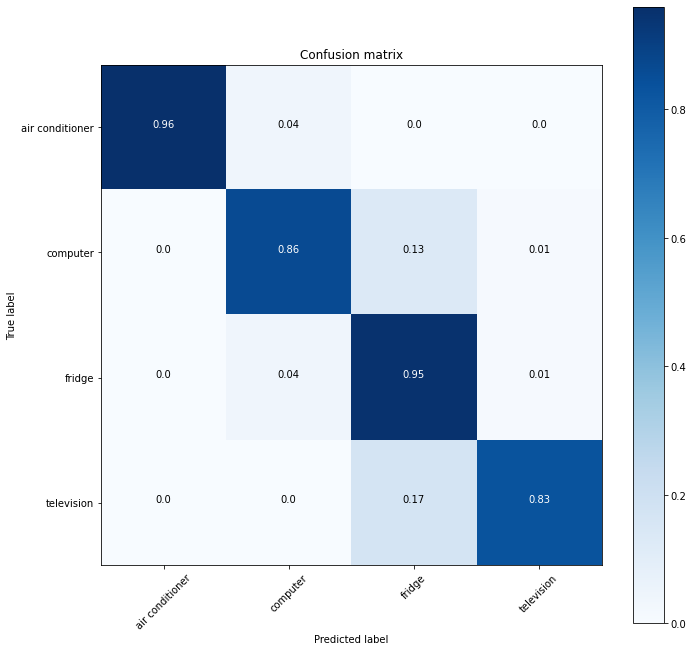

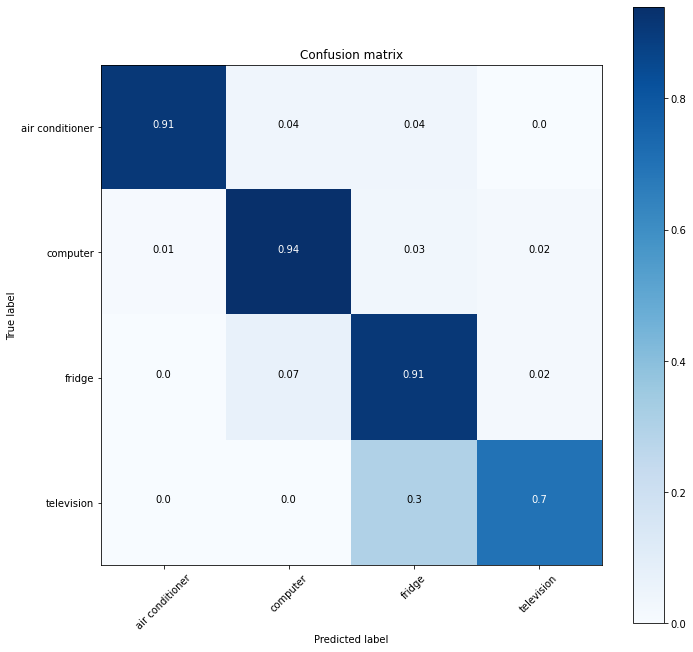

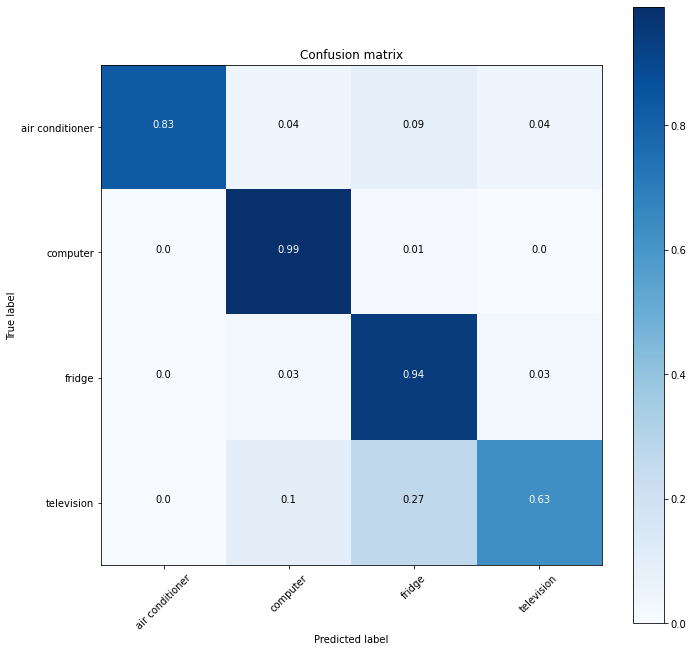

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()